In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import os,sys
from matplotlib.style import available 
import numpy as np
import pandas as pd


import backtrader as bt  # backtrader
# from backtrader.comminfo import ComminfoFuturesPercent,ComminfoFuturesFixed # 期货交易的手续费用，按照比例或者按照金额


# from backtrader.plot.plot import run_cerebro_and_plot  # 个人编写，非backtrader自带
import pyfolio as pf
from multiprocessing import Pool
from itertools import product

d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [27]:
class ETFStrategy(bt.Strategy):
    # 策略作者
    author = 'yunjinqi'
    # 策略的参数
    params = (  
                ("ma_period", 20),                
             )
    # log相应的信息
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or bt.num2date(self.datas[0].datetime[0])
        print('{}, {}'.format(dt.isoformat(), txt))

    # 初始化策略的数据
    def __init__(self):
        # 计算两个均线,直接写出，太多可以用字典保存遍历结果，参考以前的股票文章
        self.sz_ma = bt.indicators.SMA(self.datas[0].close,period=self.p.ma_period)
        self.cy_ma = bt.indicators.SMA(self.datas[1].close,period=self.p.ma_period)
        
    def prenext(self):
        # 由于期货数据有几千个，每个期货交易日期不同，并不会自然进入next
        # 需要在每个prenext中调用next函数进行运行
        self.next() 
                
    # 在next中添加相应的策略逻辑
    def next(self):
        # 两个ETF的数据
        sz_data = self.datas[0]
        cy_data = self.datas[1]
        # 计算当前是否有持仓
        self.sz_pos = self.getposition(sz_data).size
        self.cy_pos = self.getposition(cy_data).size
        # 获取两个当前的价格
        sz_close = sz_data.close[0]
        cy_close = cy_data.close[0]
        # self.log(f"{sz_close/self.sz_ma[0]},{cy_close/self.cy_ma[0]}")
        # 分析是否都小于均线，如果都小于均线，并且有持仓，平仓
        if sz_close<self.sz_ma[0] and cy_close<self.cy_ma[0]:
            if self.sz_pos>0:
                self.close(sz_data)
            if self.cy_pos>0:
                self.close(cy_data)
        # 如果两个中有一个大于均线
        if sz_close>self.sz_ma[0] or cy_close>self.cy_ma[0]:
            # 如果当前sz动量指标比较大
            if sz_close/self.sz_ma[0]>cy_close/self.cy_ma[0]:
                
                # 如果当前没有仓位，那么，就直接买入sz
                if self.sz_pos==0 and self.cy_pos==0:
                    # 获取账户价值
                    total_value = self.broker.get_value()
                    # 计算买入的量
                    lots = int(0.95*total_value/sz_close)
                    # 买入
                    self.buy(sz_data,size=lots)
                
                # 如果现在不是持有的sz,而是持有的cy,那么，就平掉创业板，然后买入sz
                if self.sz_pos==0 and self.cy_pos>0:
                    # 平仓创业板ETF
                    self.close(cy_data)
                    # 获取账户价值
                    total_value = self.broker.get_value()
                    # 计算买入的量
                    lots = int(0.95*total_value/sz_close)
                    # 买入
                    self.buy(sz_data,size=lots)
                
                # 如果当前已经买入了sz,忽略
                if self.sz_pos>0:
                    pass
                
            # 如果当前cy动量指标比较大
            if sz_close/self.sz_ma[0]<cy_close/self.cy_ma[0]:
                # 如果当前没有仓位，那么，就直接买入cy
                if self.sz_pos==0 and self.cy_pos==0:
                    # 获取账户价值
                    total_value = self.broker.get_value()
                    # 计算买入的量
                    lots = int(0.95*total_value/cy_close)
                    # 买入
                    self.buy(cy_data,size=lots)
                
                # 如果现在不是持有的sz,而是持有的cy,那么，就平掉创业板，然后买入sz
                if self.sz_pos>0 and self.cy_pos==0:
                    # 平仓创业板ETF
                    self.close(sz_data)
                    # 获取账户价值
                    total_value = self.broker.get_value()
                    # 计算买入的量
                    lots = int(0.95*total_value/cy_close)
                    # 买入
                    self.buy(cy_data,size=lots)
                
                # 如果当前已经买入了cy,忽略
                if self.cy_pos>0:
                    pass            
                
    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status == order.Rejected:
            self.log(f"Rejected : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Margin:
            self.log(f"Margin : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Cancelled:
            self.log(f"Concelled : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Partial:
            self.log(f"Partial : order_ref:{order.ref}  data_name:{order.p.data._name}")
         
        if order.status == order.Completed:
            if order.isbuy():
                self.log(f" BUY : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")

            else:  # Sell
                self.log(f" SELL : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")
    
    def notify_trade(self, trade):
        # 一个trade结束的时候输出信息
        if trade.isclosed:
            self.log('closed symbol is : {} , total_profit : {} , net_profit : {}' .format(
                            trade.getdataname(),trade.pnl, trade.pnlcomm))
            # self.trade_list.append([self.datas[0].datetime.date(0),trade.getdataname(),trade.pnl,trade.pnlcomm])
            
        if trade.isopen:
            self.log('open symbol is : {} , price : {} ' .format(
                            trade.getdataname(),trade.price))


In [28]:

def run():
    
    # 准备配置策略
    cerebro = bt.Cerebro()
    # 参数设置
    # data_kwargs = dict(
    #             # fromdate = datetime.datetime(2012,12, 3),
    #             # todate = datetime.datetime(2021,7,31),
    #             timeframe = bt.TimeFrame.Minutes,
    #             compression = 1,
    #             dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和时间格式
    #             tmformat=('%H:%M:%S'), # 时间格式
    #             datetime=0,
    #             high=3,
    #             low=4,
    #             open=1,
    #             close=2,
    #             volume=5,
    #             openinterest=6)
    
    # 处理上证50数据
    df1 = pd.read_csv("D:/quant_datas/etf/510050.csv")
    # volume和openinterest都是随机填写的数字，仅仅方便直接传入，无意义
    df1['volume']=1000000
    df1['openinterest']=1000000
    df1.index = pd.to_datetime(df1["datetime"])
    df1=df1[['open','high',"low","close","volume",'openinterest']]
    df1 = df1[df1.index>=pd.to_datetime("2011-09-20")]
    # print(df1.head())
    feed = bt.feeds.PandasDirectData(dataname = df1)
    # feed = bt.feeds.GenericCSVData(dataname = data_path,**data_kwargs)
    cerebro.adddata(feed, name = "sz")
    
    # 处理创业板数据
    df2 = pd.read_csv("D:/quant_datas/etf/563300.csv")
    # volume和openinterest都是随机填写的数字，仅仅方便直接传入，无意义
    df2['volume']=1000000
    df2['openinterest']=1000000
    df2.index = pd.to_datetime(df2["datetime"])
    df2=df2[['open','high',"low","close","volume",'openinterest']]

    feed = bt.feeds.PandasDirectData(dataname = df2)
    # feed = bt.feeds.GenericCSVData(dataname = data_path,**data_kwargs)
    cerebro.adddata(feed, name = "cy")
    
    # 设置初始资金
    cerebro.broker.setcash(50000.0)
    # 添加手续费，按照万分之二收取，频繁交易，加上手续费亏的很惨，这里先忽略手续费
    cerebro.broker.setcommission(commission=0.0002, stocklike=True)
    
    cerebro.addstrategy(ETFStrategy)
    # cerebro.addanalyzer(bt.analyzers.TotalValue, _name='my_valu')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='my_sharpe')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='my_returns')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='my_drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='my_trade_analyzer')

    cerebro.addanalyzer(bt.analyzers.PyFolio)

    # 运行回测
    results = cerebro.run()
    sharpe_ratio = results[0].analyzers.my_sharpe.get_analysis()['sharperatio']
    annual_return = results[0].analyzers.my_returns.get_analysis()['rnorm']
    max_drawdown = results[0].analyzers.my_drawdown.get_analysis()["max"]["drawdown"]/100
    trade_num = results[0].analyzers.my_trade_analyzer.get_analysis()['total']['total']
    # value_df = pd.DataFrame([results[0].analyzers.my_value.get_analysis()]).T
    # value_df.columns=['value']
    # value_df['datetime']=pd.to_datetime(value_df.index)
    # value_df['date']=[i.date() for i in value_df['datetime']]
    # value_df= value_df.drop_duplicates("date",keep="last")
    # value_df = value_df[['value']]
    # value_df.to_csv("ETF策略的测试结果.csv")
    print(f"夏普率：{sharpe_ratio},年化收益率:{annual_return},最大回撤：{max_drawdown},交易次数:{trade_num}")
    return results


2011-10-25T00:00:00,  BUY : data_name:sz price : 1.889 , cost : 47474.348 , commission : 9.494869600000001
2011-10-25T00:00:00, open symbol is : sz , price : 1.889 
2011-11-17T00:00:00,  SELL : data_name:sz price : 1.918 , cost : 47474.348 , commission : 9.6406352
2011-11-17T00:00:00, closed symbol is : sz , total_profit : 728.8279999999978 , net_profit : 709.6924951999978
2012-01-10T00:00:00,  BUY : data_name:sz price : 1.819 , cost : 48041.609 , commission : 9.6083218
2012-01-10T00:00:00, open symbol is : sz , price : 1.819 
2012-03-07T00:00:00,  SELL : data_name:sz price : 1.944 , cost : 48041.609 , commission : 10.268596800000001
2012-03-07T00:00:00, closed symbol is : sz , total_profit : 3301.375 , net_profit : 3281.4980814
2012-03-12T00:00:00,  BUY : data_name:sz price : 1.97 , cost : 51290.92 , commission : 10.258184
2012-03-12T00:00:00, open symbol is : sz , price : 1.97 
2012-03-13T00:00:00,  SELL : data_name:sz price : 1.958 , cost : 51290.92 , commission : 10.1956976
2012-03

d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\utils.py:297: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  warnings.warn('Detected intraday strategy; inferring positi' +
d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' ins

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.46,2018-02-05,2019-01-14,NaT,NaN
1,23.09,2015-04-27,2016-06-30,2017-11-21,672
2,21.14,2013-02-06,2014-06-27,2014-12-03,476
3,15.66,2015-01-05,2015-03-10,2015-04-13,71
4,14.30,2012-03-02,2012-12-06,2013-01-28,237


d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\timeseries.py:1141: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\timeseries.py:1141: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\plotting.py:1304: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(data=[is_returns, is_weekly, is_monthly],
d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\plotting.py:1320: UserWarning: FixedFormatter should only 

Stress Events,mean,min,max
EZB IR Event,-0.03%,-1.52%,1.96%
Apr14,0.06%,-1.59%,2.41%
Oct14,0.09%,-0.64%,1.77%
Fall2015,-0.07%,-2.13%,0.94%
Recovery,0.03%,-2.42%,4.52%
New Normal,0.01%,-8.70%,7.31%


Top 10 long positions of all time,max
sid,
sz,97.06%
cy,95.75%


Top 10 short positions of all time,max
sid,
sz,-3216.17%


Top 10 positions of all time,max
sid,
sz,3216.17%
cy,95.75%


d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\plotting.py:1553: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(turnover, ax=ax, **kwargs)
d:\minicoda\envs\quant\lib\site-packages\pyfolio-0+unknown-py3.8.egg\pyfolio\plotting.py:1633: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  txn_time = txn_time.groupby(level=0).sum().reindex(index=range(570, 961))


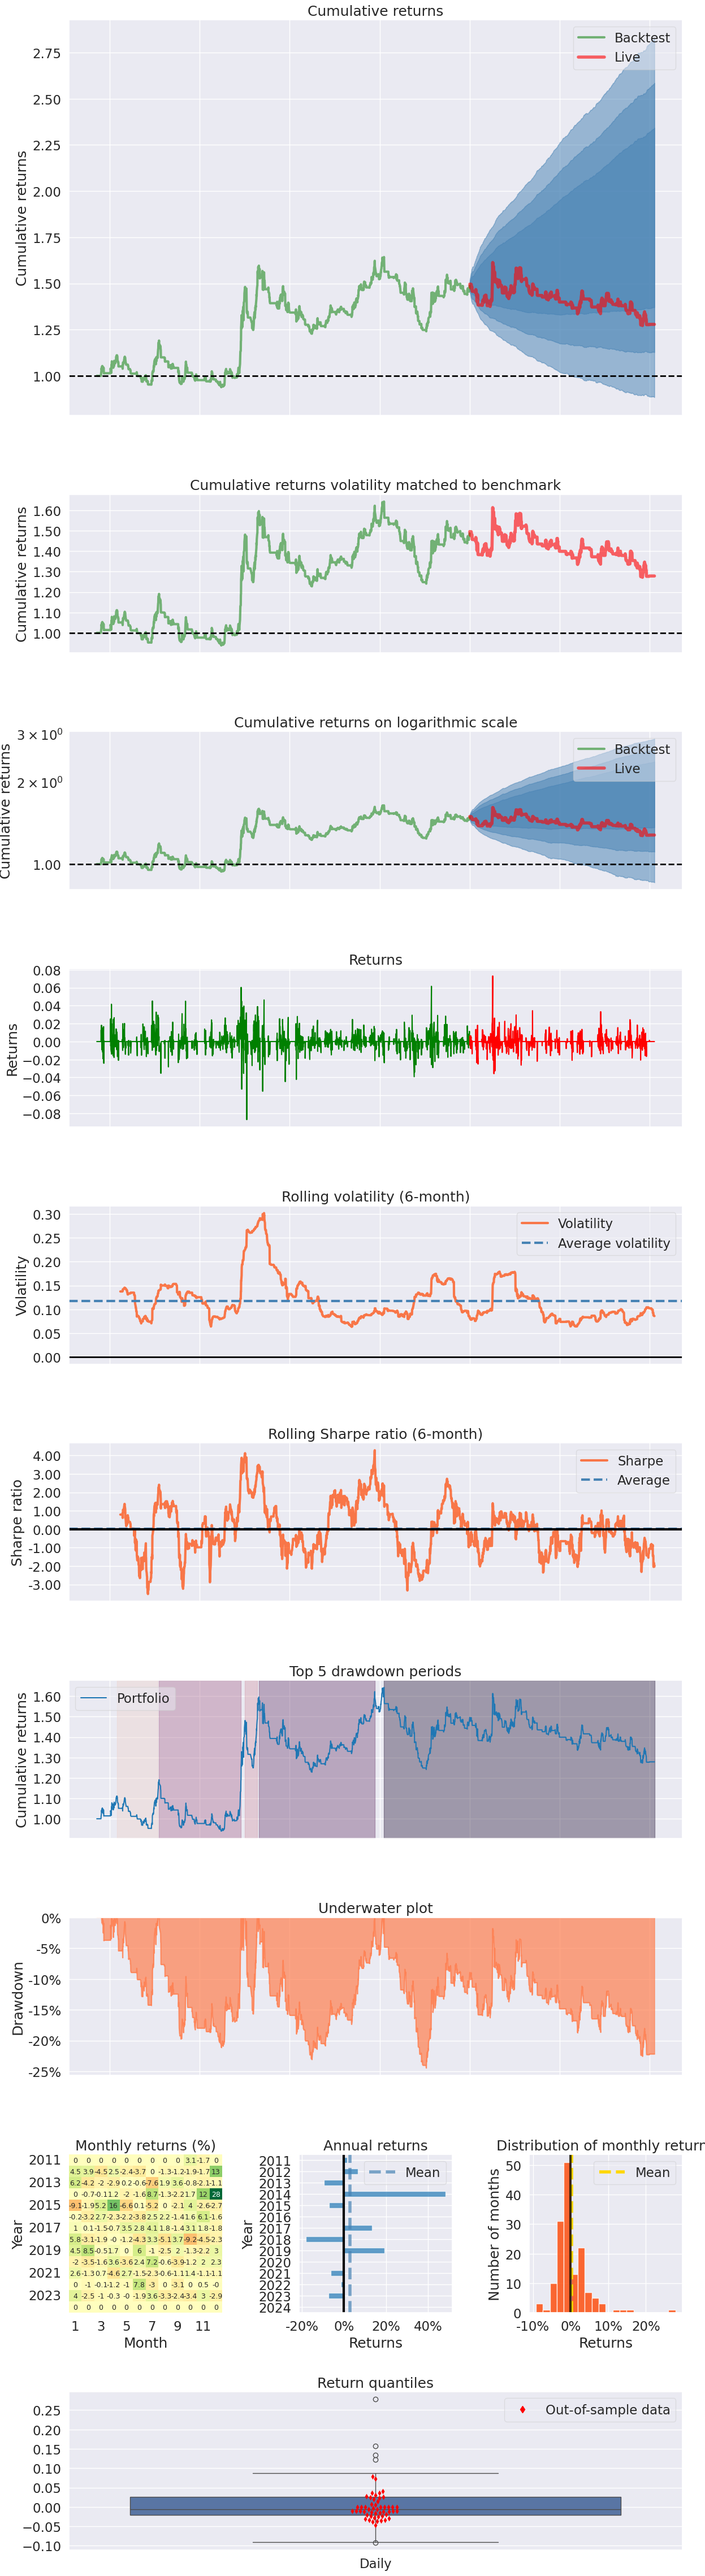

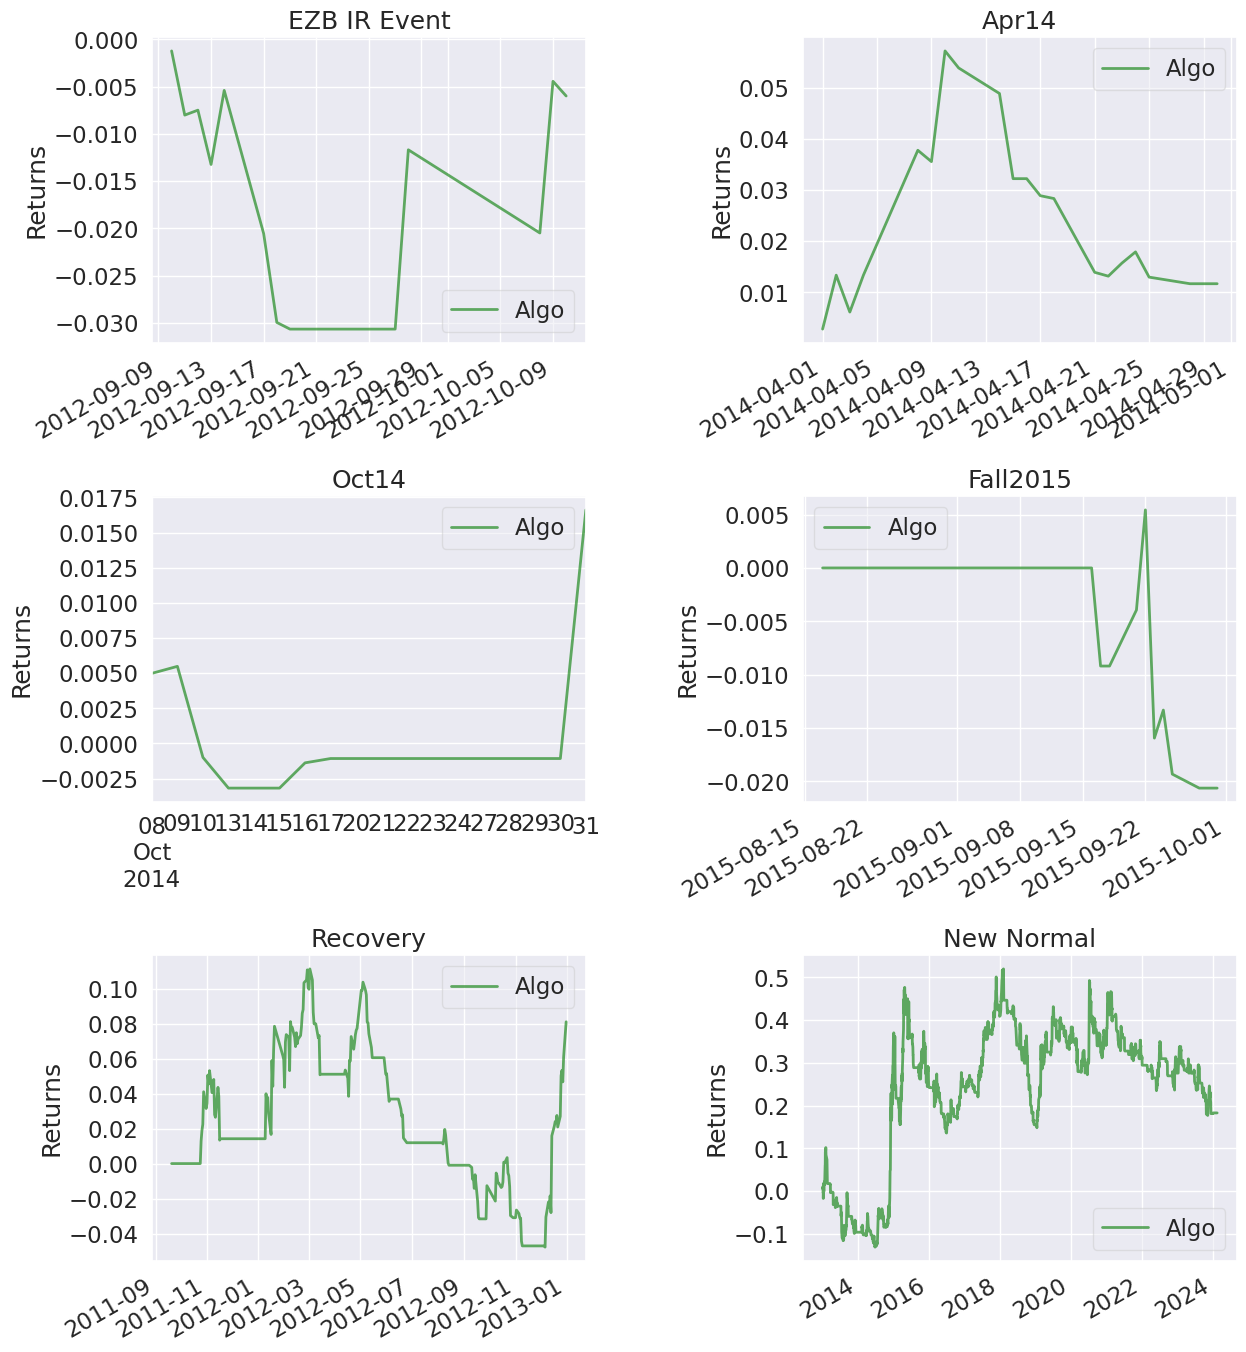

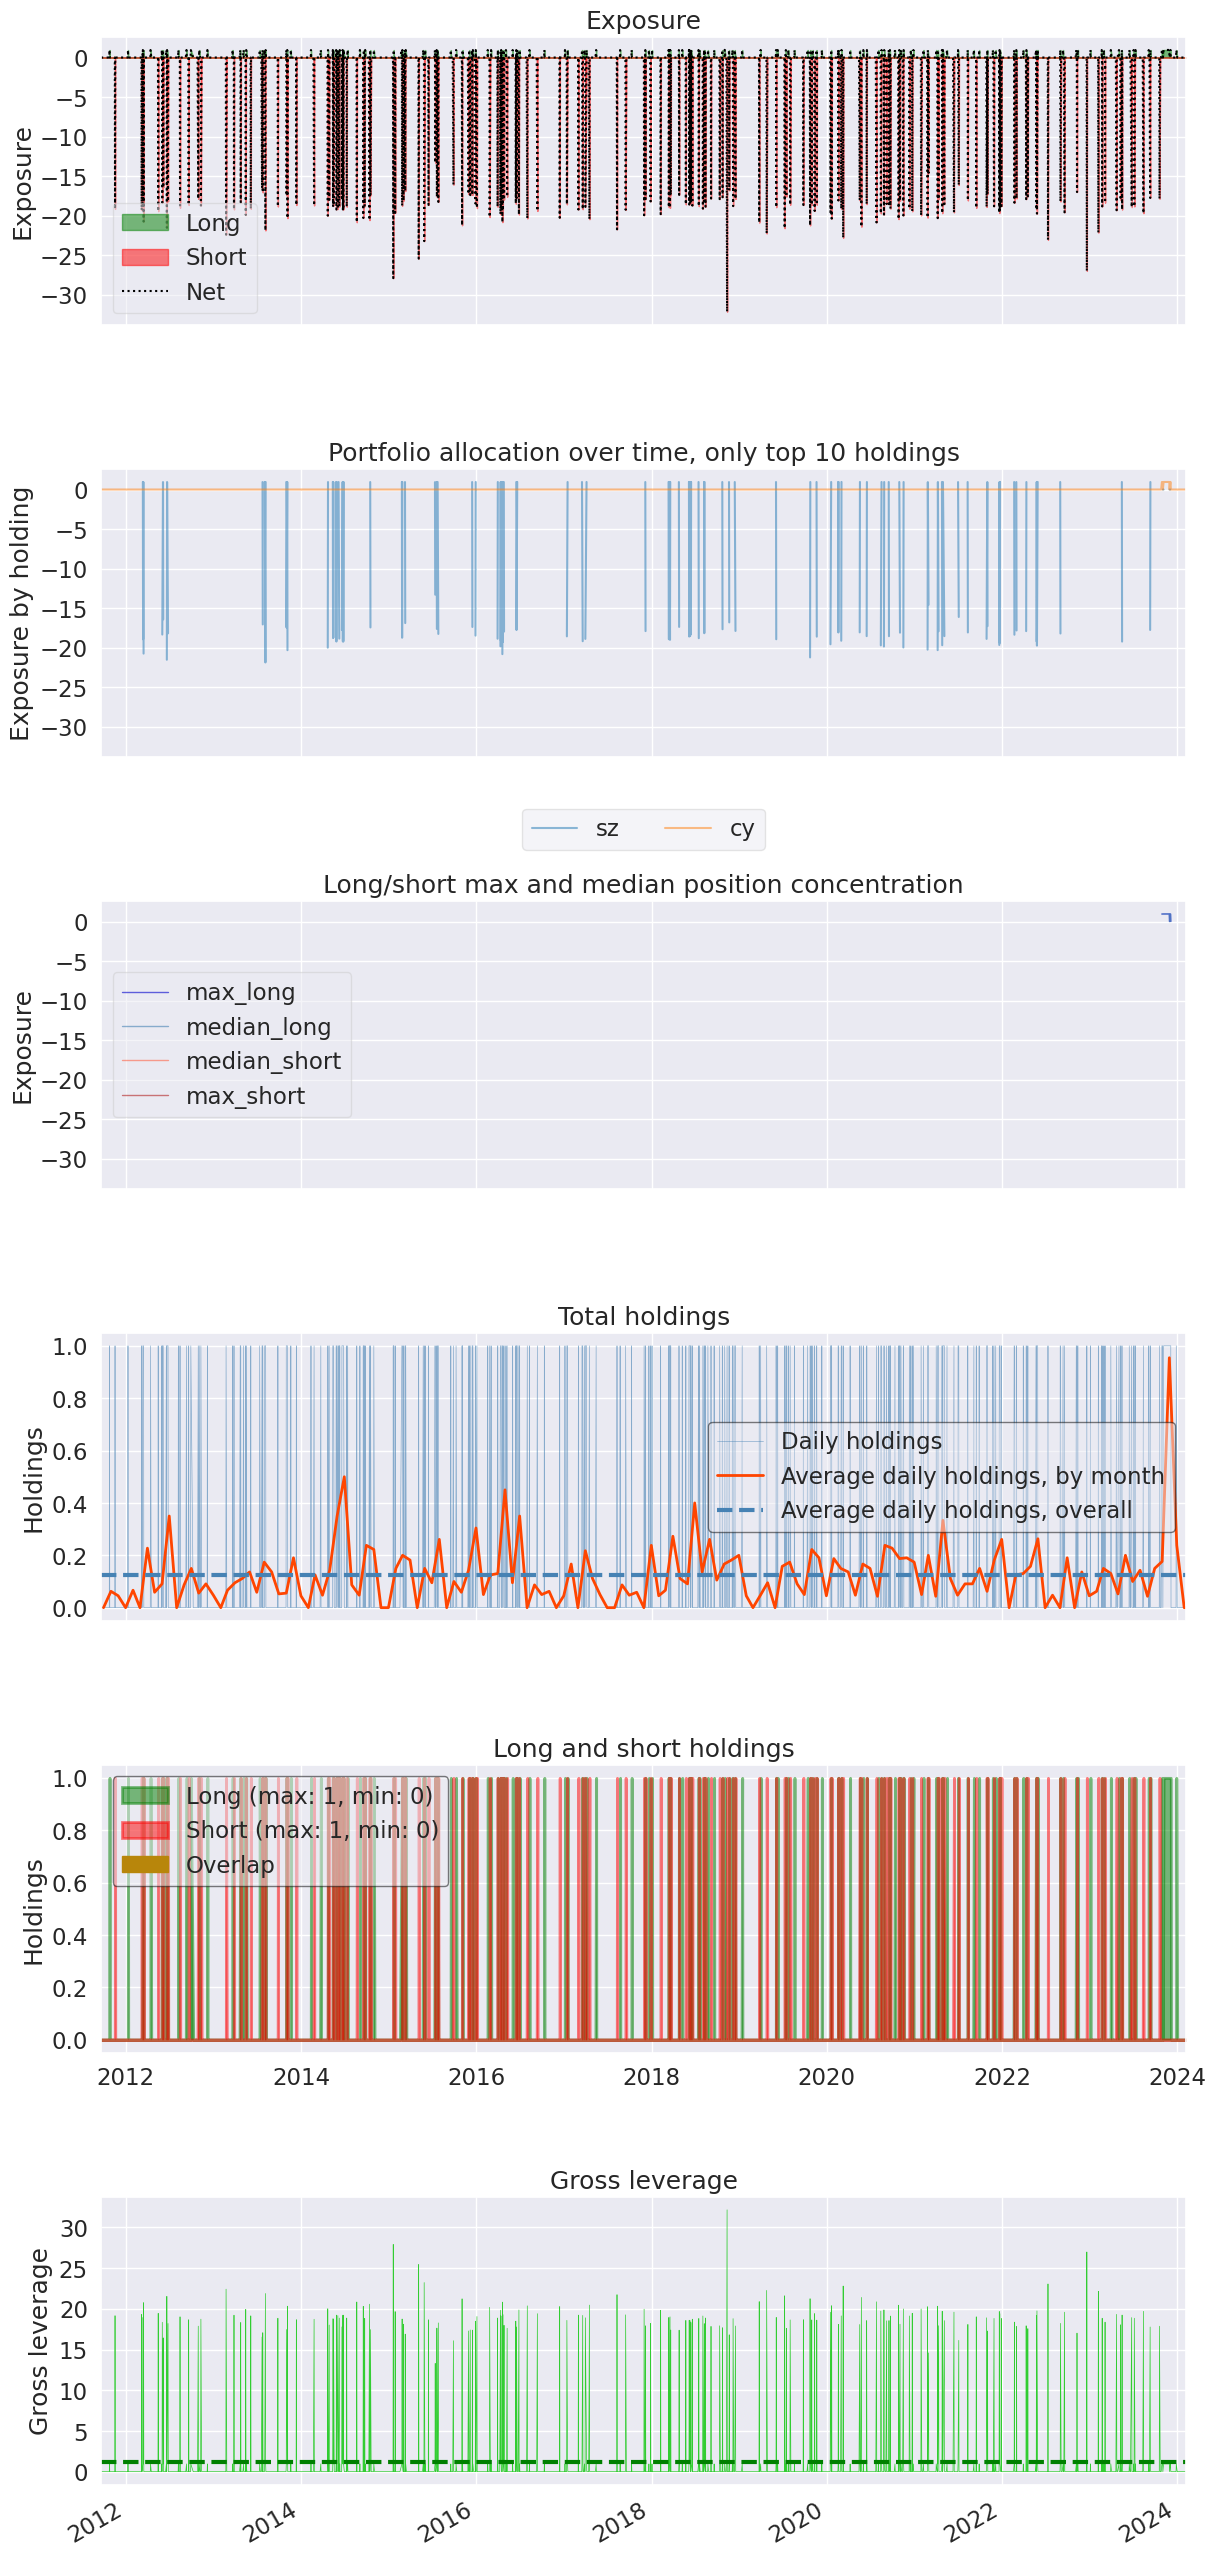

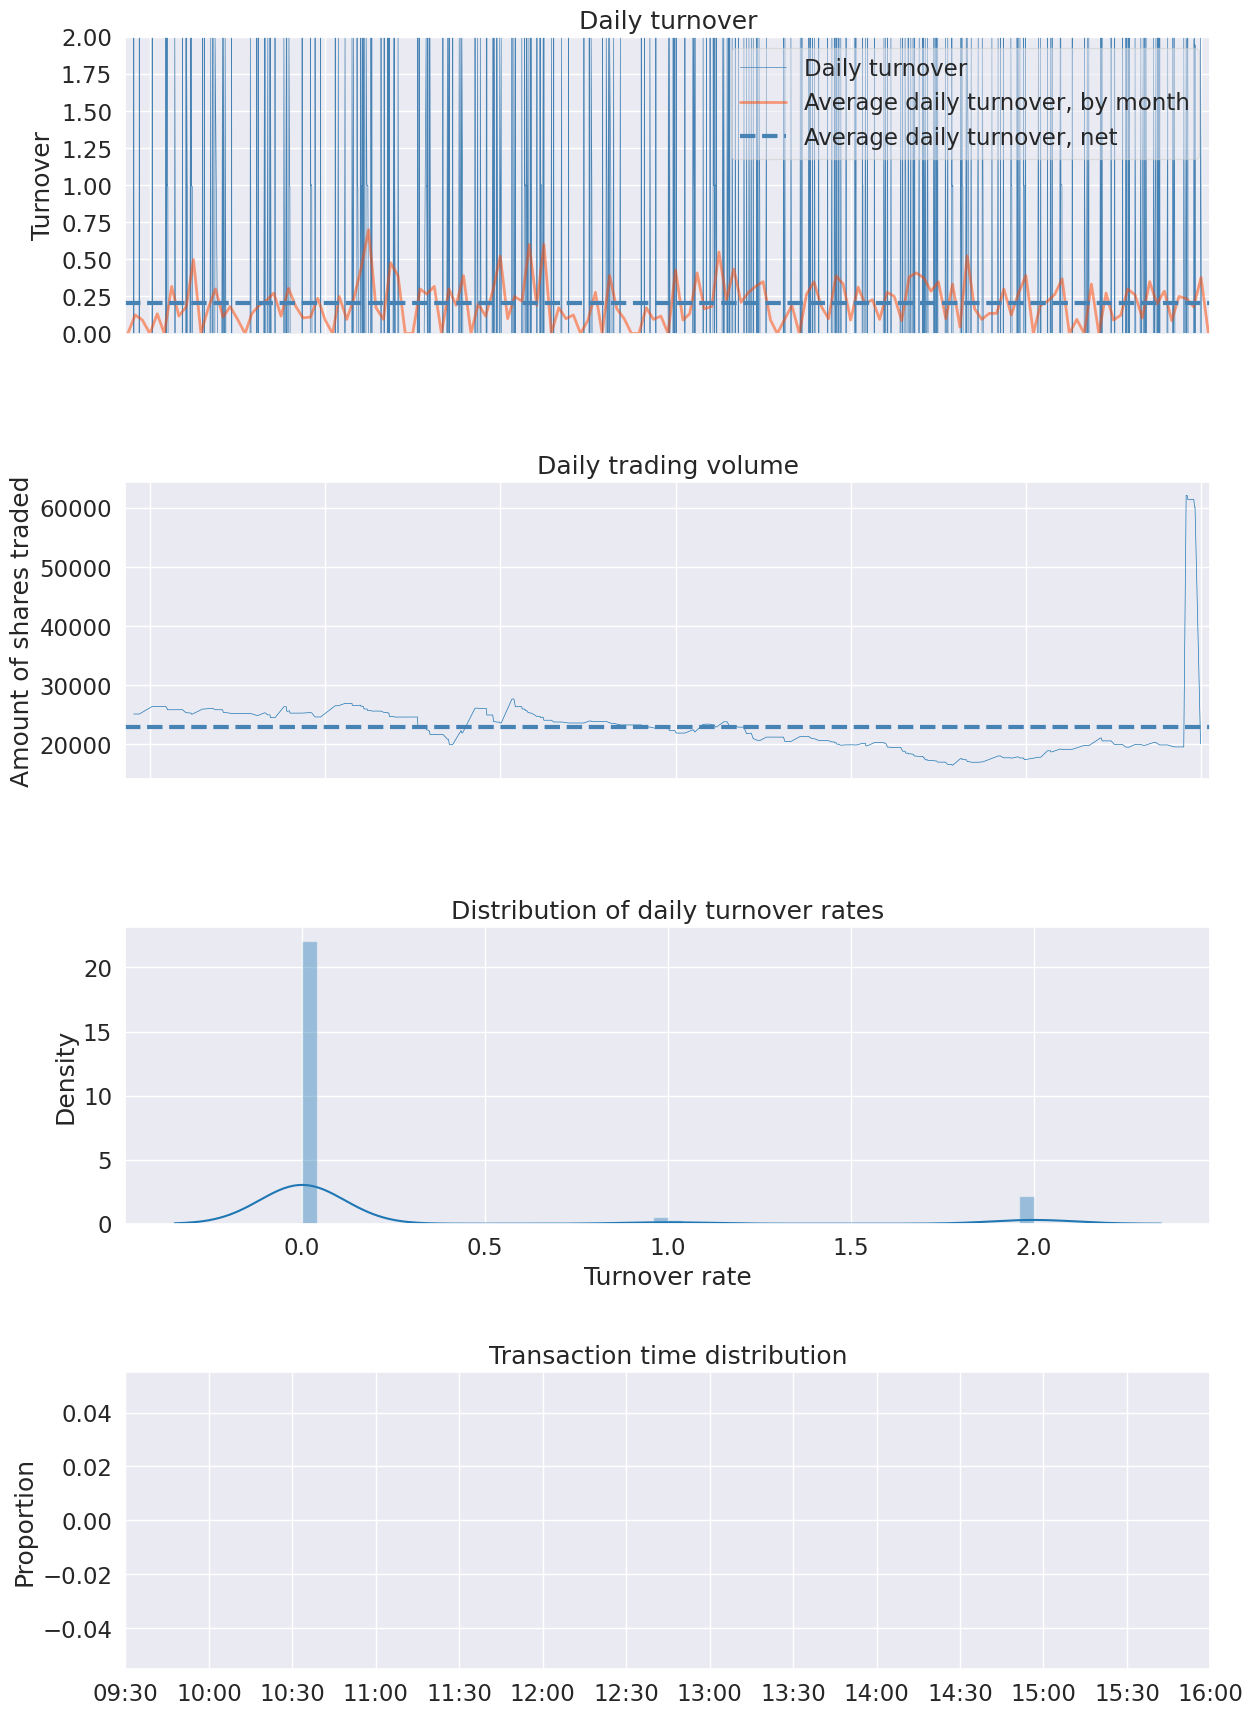

In [29]:
results = run()

pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2020-01-01',
    )